# Intensity Control

In this notebook we will evaluate the signal quality of the intensity controller and estimate an error by comparison with voltage differences in intensity measurements.

In [1]:
import os
import numpy as np
import pandas as pd

datadir = '../../dataset/intensity'
figuredir = '../../figure/intensity/control'

from matplotlib import dates as mdates

os.makedirs(figuredir, exist_ok=True)

In [48]:
long = pd.read_hdf(os.path.join(datadir, 'control.h5'), 'long')
long.time = pd.to_datetime(long.time, format='%Y-%m-%d_%H%M%S')

short = pd.read_hdf(os.path.join(datadir, 'control.h5'), 'short')
short.time = pd.to_datetime(short.time, format='%Y-%m-%d_%H%M%S')

unctrl = pd.read_hdf(os.path.join(datadir, 'control.h5'), 'uncontrolled')
unctrl.time = pd.to_datetime(unctrl.time, format='%Y-%m-%d_%H%M%S')

In [49]:
long.voltage.mean(), long.voltage.min(), long.voltage.max(), long.voltage.std(), long.voltage.std() / long.voltage.mean()

(6.790721721811591,
 4.883208036031497,
 6.864006856101877,
 0.09186888609865777,
 0.013528589428657886)

In [50]:
short.voltage.mean(), short.voltage.min(), short.voltage.max(), short.voltage.std(), short.voltage.std() / short.voltage.mean()

(6.789301355971451,
 6.765777897547424,
 6.822276358793229,
 0.012768993779543474,
 0.001880752246814417)

In [51]:
unctrl.voltage.mean(), unctrl.voltage.min(), unctrl.voltage.max(), unctrl.voltage.std(), unctrl.voltage.std() / unctrl.voltage.mean()

(8.454508572287686,
 7.429995090951206,
 9.08381666993267,
 0.48602699028174745,
 0.05748731415032849)

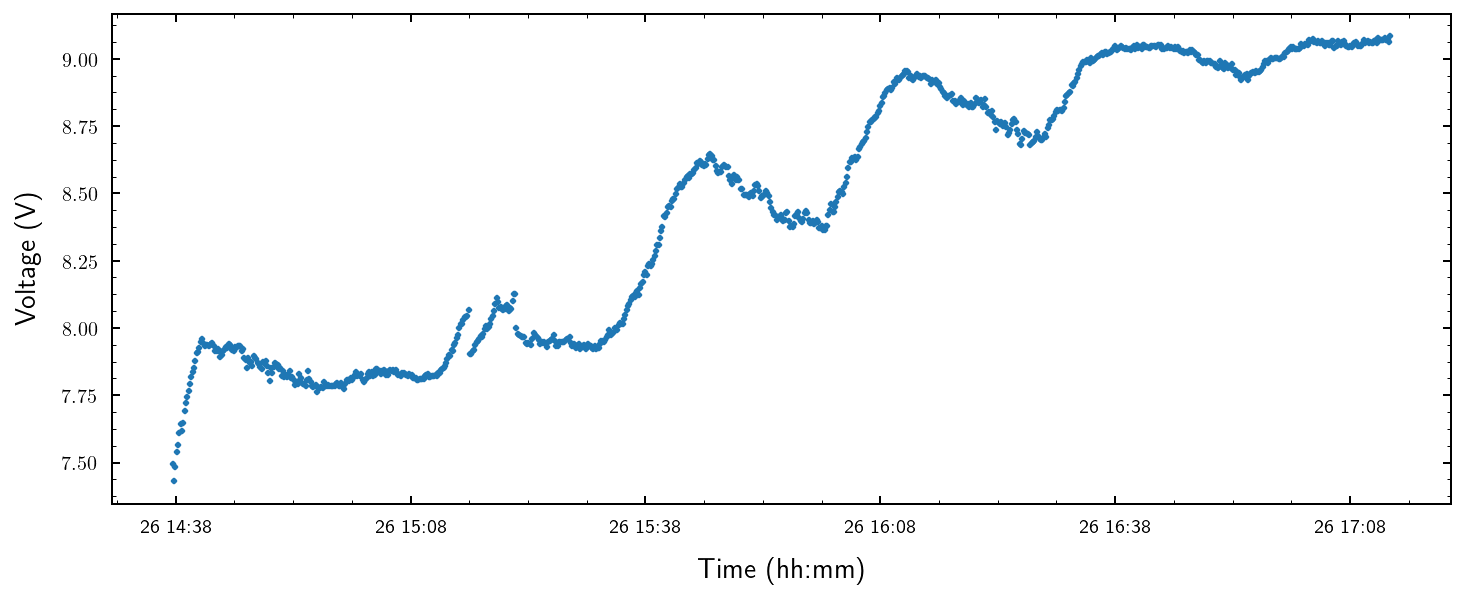

In [73]:
fig = plt.figure(figsize=(12, 5))
fig.autofmt_xdate()

plt.plot(unctrl.time.astype('O'), unctrl.voltage, marker='x', markersize=2, linestyle='none')
plt.xlabel('Time (hh:mm)')
plt.ylabel('Voltage (V)')
plt.savefig(os.path.join(figuredir, 'uncontrolled.pdf'))
plt.show()


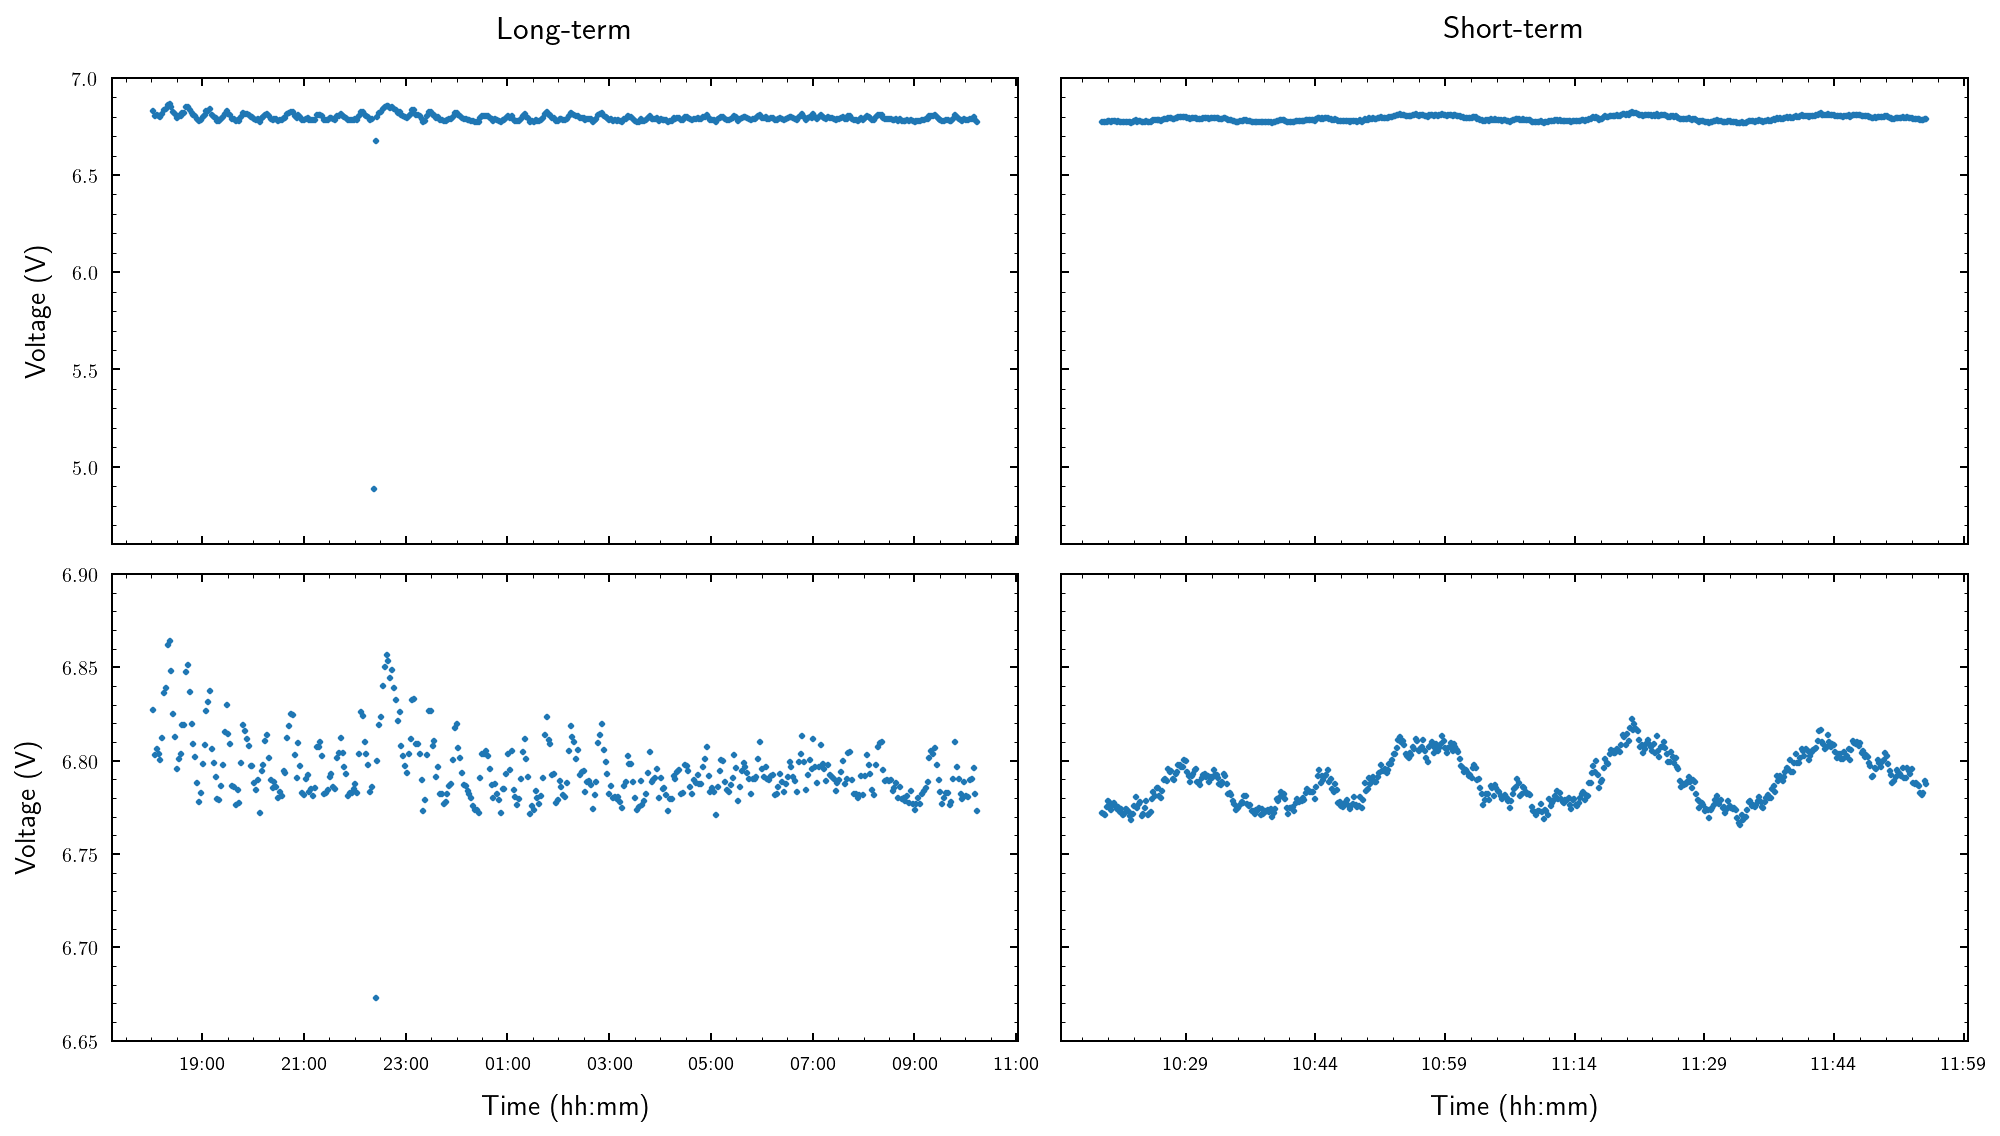

In [74]:
fig = plt.figure(figsize=(14, 8))
fig.autofmt_xdate()

ax0 = fig.add_subplot(221)
ax0.set_title('Long-term')
ax0.plot(long.time.astype('O'), long.voltage, marker='x', markersize=2, linestyle='none')
ax0.set_ylim(4.6, 7)

ax1 = fig.add_subplot(222)
ax1.set_title('Short-term')
ax1.plot(short.time.astype('O'), short.voltage, marker='x', markersize=2, linestyle='none')
ax1.set_ylim(4.6, 7)

ax2 = fig.add_subplot(223)
ax2.plot(long.time.astype('O'), long.voltage, marker='x', markersize=2, linestyle='none')
ax2.set_ylim(6.65, 6.9)

ax3 = fig.add_subplot(224)
ax3.plot(short.time.astype('O'), short.voltage, marker='x', markersize=2, linestyle='none')
ax3.set_ylim(6.65, 6.9)

ax2.get_shared_x_axes().join(ax0, ax2)
ax2.set_xlabel('Time (hh:mm)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax0.set_xticklabels([])

ax3.get_shared_x_axes().join(ax1, ax3)
ax3.set_xlabel('Time (hh:mm)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xticklabels([])

ax0.get_shared_y_axes().join(ax0, ax1)
ax0.set_ylabel('Voltage (V)')
ax1.set_yticklabels([])

ax2.get_shared_y_axes().join(ax2, ax3)
ax2.set_ylabel('Voltage (V)')
ax3.set_yticklabels([])

plt.tight_layout()
plt.savefig(os.path.join(figuredir, 'long-short.pdf'))
plt.show()

In [61]:
df = pd.read_hdf(os.path.join(datadir, 'anticipated-frequency.h5'), 'vsweep')

t = df.time
U = df['voltage@100.00MHz']

def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def relative_deviation(x):
    return (x - x.mean()) / x.mean()

U_t = relative_deviation(U)
U_l = relative_deviation(long.voltage)
U_s = relative_deviation(short.voltage)
U_u = relative_deviation(unctrl.voltage)

In [58]:
U.mean(), U.min(), U.max(), U.std(), U.std() / U.mean()

(1.9526885502323434,
 -0.02503887808000016,
 3.0022416646399996,
 0.5406122336698029,
 0.27685533036258003)

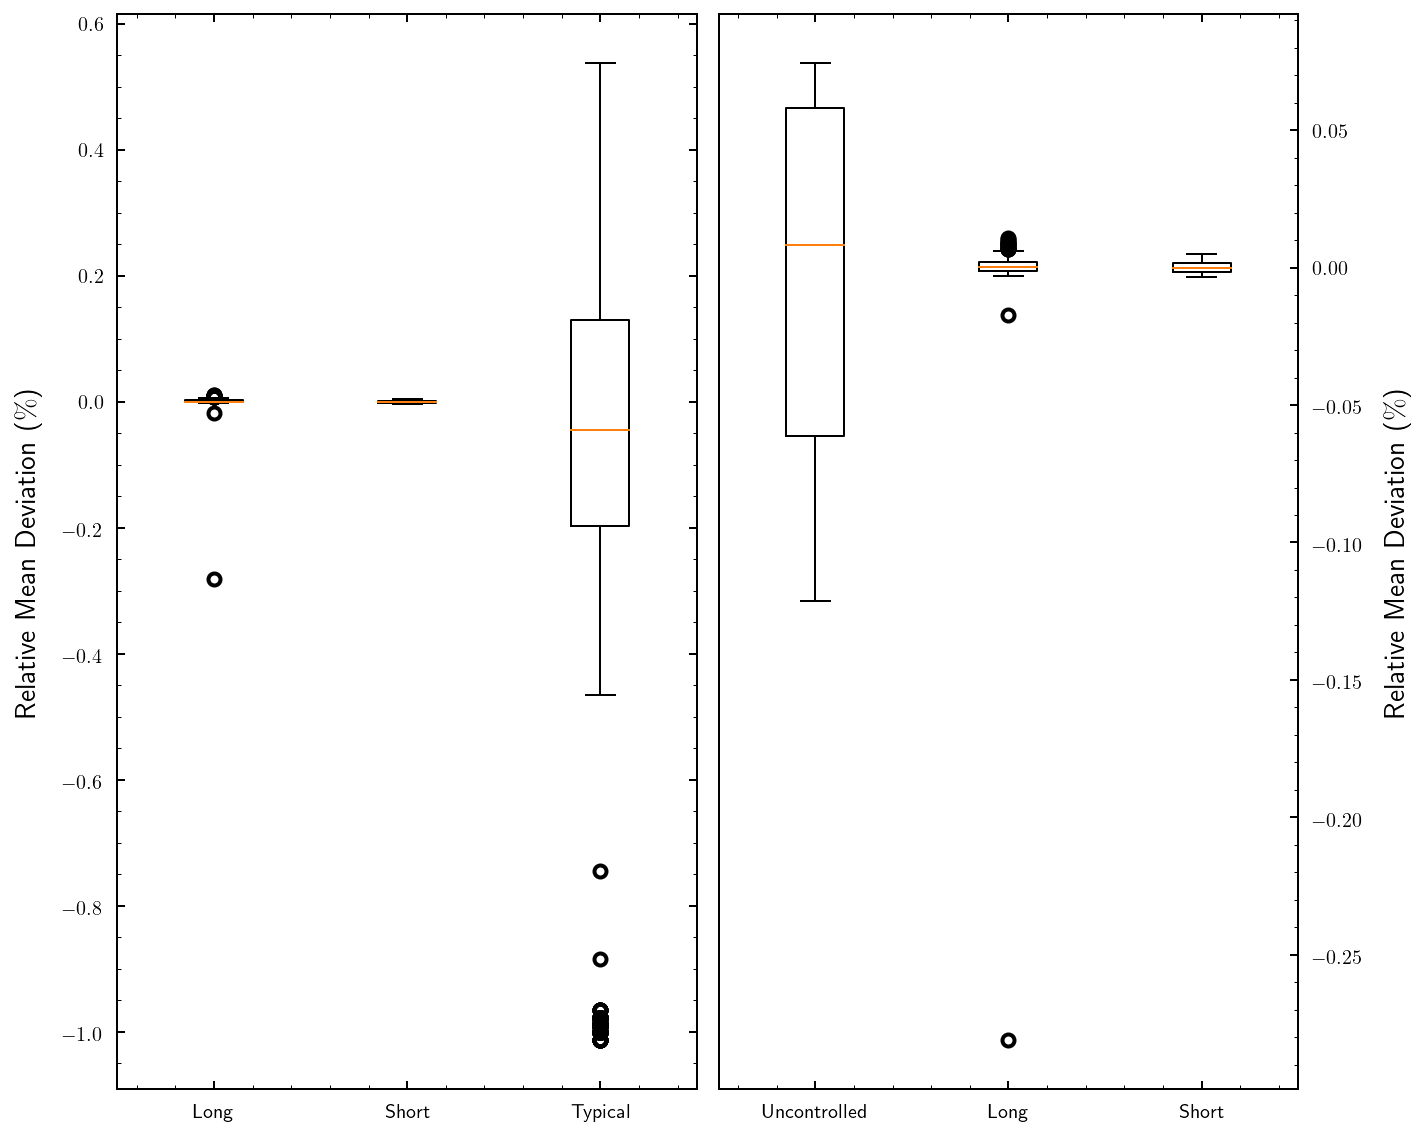

In [87]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 8))

axes[0].boxplot([U_l, U_s, U_t])
axes[0].set_xticklabels(['Long', 'Short', 'Typical'])

axes[0].set_ylabel(r'Relative Mean Deviation (\si{\percent})')

axes[1].boxplot([U_u, U_l, U_s])
axes[1].set_xticklabels(['Uncontrolled', 'Long', 'Short'])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')
axes[1].set_ylabel(r'Relative Mean Deviation (\si{\percent})')

plt.tight_layout()
plt.savefig(os.path.join(figuredir, 'relative-mean-deviation.pdf'))
plt.show()